In [1]:
# Import Modules
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
import datetime
from pandas_datareader import data as pdr
import yfinance as yf
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.svm import SVC


In [2]:
# Collect and prepare the stock data

In [3]:
# use QQQ as the ticker
ticker = yf.Ticker("QQQ")

In [4]:
# Dataset period
ticker_df = ticker.history(start="2012-01-01", end="2021-12-31")

display(ticker_df.head())
display(ticker_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03,51.671313,51.925538,51.526042,51.662235,39514100,0.0,0
2012-01-04,51.580514,51.952772,51.353527,51.880135,29403400,0.0,0
2012-01-05,51.771180,52.352266,51.571431,52.306870,41260600,0.0,0
2012-01-06,52.315941,52.606484,52.116195,52.488453,46325200,0.0,0
2012-01-09,52.624659,52.642818,52.143447,52.315956,39195500,0.0,0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-12-23,394.309998,398.429993,394.140015,396.920013,29595500,0.0,0
2021-12-27,398.250000,403.480011,398.220001,403.480011,32820700,0.0,0
2021-12-28,404.399994,404.579987,400.709991,401.609985,33113700,0.0,0
2021-12-29,401.750000,403.049988,399.109985,401.549988,32248500,0.0,0
2021-12-30,401.329987,403.570007,399.750000,400.350006,23850100,0.0,0


In [5]:
# Create the Features Set

In [6]:
# Filter the date index and close columns
signals_df = ticker_df.loc[:, ["Close"]]
# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()
# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()
# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2012-01-04,51.880135,0.004218
2012-01-05,52.306870,0.008225
2012-01-06,52.488453,0.003472
2012-01-09,52.315956,-0.003286
2012-01-10,52.697289,0.007289


,Close,Actual Returns
Date,,
2021-12-23,396.920013,0.007539
2021-12-27,403.480011,0.016527
2021-12-28,401.609985,-0.004635
2021-12-29,401.549988,-0.000149
2021-12-30,400.350006,-0.002988


In [7]:
# Set the short window and long window
short_window = 7
long_window = 25

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2012-02-08,56.710411,0.005311,55.955520,54.228085
2012-02-09,57.118984,0.007205,56.264222,54.437639
2012-02-10,56.719501,-0.006994,56.452298,54.614144
2012-02-13,57.246094,0.009284,56.690957,54.804450
2012-02-14,57.391373,0.002538,56.841418,55.007466


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396
2021-12-27,403.480011,0.016527,390.716513,392.930095
2021-12-28,401.609985,-0.004635,392.897003,392.855508
2021-12-29,401.549988,-0.000149,395.344286,392.965881
2021-12-30,400.350006,-0.002988,398.152858,393.100962


In [8]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2012-02-08,56.710411,0.005311,55.955520,54.228085,1.0
2012-02-09,57.118984,0.007205,56.264222,54.437639,1.0
2012-02-10,56.719501,-0.006994,56.452298,54.614144,-1.0
2012-02-13,57.246094,0.009284,56.690957,54.804450,1.0
2012-02-14,57.391373,0.002538,56.841418,55.007466,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396,1.0
2021-12-27,403.480011,0.016527,390.716513,392.930095,1.0
2021-12-28,401.609985,-0.004635,392.897003,392.855508,-1.0
2021-12-29,401.549988,-0.000149,395.344286,392.965881,-1.0
2021-12-30,400.350006,-0.002988,398.152858,393.100962,-1.0


In [9]:
signals_df['Signal'].value_counts()

 1.0    1421
-1.0    1070
Name: Signal, dtype: int64

In [10]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2012-02-08,56.710411,0.005311,55.955520,54.228085,1.0,NaN
2012-02-09,57.118984,0.007205,56.264222,54.437639,1.0,0.007205
2012-02-10,56.719501,-0.006994,56.452298,54.614144,-1.0,-0.006994
2012-02-13,57.246094,0.009284,56.690957,54.804450,1.0,-0.009284
2012-02-14,57.391373,0.002538,56.841418,55.007466,1.0,0.002538


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2021-12-23,396.920013,0.007539,389.725586,392.840396,1.0,0.007539
2021-12-27,403.480011,0.016527,390.716513,392.930095,1.0,0.016527
2021-12-28,401.609985,-0.004635,392.897003,392.855508,-1.0,-0.004635
2021-12-29,401.549988,-0.000149,395.344286,392.965881,-1.0,0.000149
2021-12-30,400.350006,-0.002988,398.152858,393.100962,-1.0,0.002988


<AxesSubplot:xlabel='Date'>

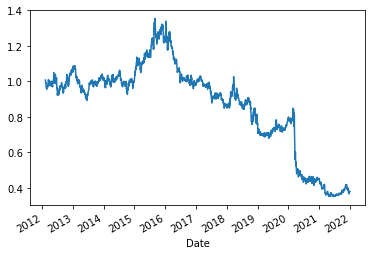

In [11]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [12]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna().copy()

# Review the DataFrame
display(X.head())
display(X.tail())

,SMA_Fast,SMA_Slow
Date,,
2012-02-09,55.955520,54.228085
2012-02-10,56.264222,54.437639
2012-02-13,56.452298,54.614144
2012-02-14,56.690957,54.804450
2012-02-15,56.841418,55.007466


,SMA_Fast,SMA_Slow
Date,,
2021-12-23,388.409132,392.848507
2021-12-27,389.725586,392.840396
2021-12-28,390.716513,392.930095
2021-12-29,392.897003,392.855508
2021-12-30,395.344286,392.965881


In [13]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    1421
-1.0    1070
Name: Signal, dtype: int64

In [14]:
# Select the start of the training period
training_begin = X.index.max() - DateOffset(months=30)

# Display the training begin date
print(training_begin)

2019-06-30 00:00:00


In [15]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.max()  - DateOffset(months=3)

# Display the training end date
print(training_end)

2021-09-30 00:00:00


In [16]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

,SMA_Fast,SMA_Slow
Date,,
2019-07-01,184.236731,178.801696
2019-07-02,184.353097,179.254724
2019-07-03,184.614378,179.763667
2019-07-05,185.076128,180.386402
2019-07-08,185.937690,180.964659


,SMA_Fast,SMA_Slow
Date,,
2021-09-24,371.431070,374.389194
2021-09-27,370.817378,374.779618
2021-09-28,369.741464,374.900554
2021-09-29,367.808794,374.383348
2021-09-30,366.892822,373.797081


In [17]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())

,SMA_Fast,SMA_Slow
Date,,
2021-10-01,365.724317,373.140923
2021-10-04,364.384600,372.668424
2021-10-05,361.479736,371.749456
2021-10-06,359.204075,370.852246
2021-10-07,357.680307,370.058889


,SMA_Fast,SMA_Slow
Date,,
2021-12-23,388.409132,392.848507
2021-12-27,389.725586,392.840396
2021-12-28,390.716513,392.930095
2021-12-29,392.897003,392.855508
2021-12-30,395.344286,392.965881


In [19]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# From SVM, instantiate SVC classifier model instance
# Classification report on Train is not helpful
from sklearn.svm import SVC
svm_model = SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
from sklearn.metrics import classification_report
svm_training_report = classification_report(y_train, svm_pred)
print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       230
         1.0       0.60      1.00      0.75       339

    accuracy                           0.60       569
   macro avg       0.30      0.50      0.37       569
weighted avg       0.35      0.60      0.44       569



/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = svm_model.predict(X_test_scaled)

# Print the classification report
print (classification_report(y_test, svm_testing_report))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        25
         1.0       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_testing_report

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']

predictions_df['Trading Algorithm Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']


# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-10-01,1.0,0.006202,-0.006202,0.006202
2021-10-04,1.0,-0.020989,-0.020989,-0.020989
2021-10-05,1.0,0.013499,-0.013499,0.013499
2021-10-06,1.0,0.006408,0.006408,0.006408
2021-10-07,1.0,0.009175,0.009175,0.009175


,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-12-23,1.0,0.007539,0.007539,0.007539
2021-12-27,1.0,0.016527,0.016527,0.016527
2021-12-28,1.0,-0.004635,-0.004635,-0.004635
2021-12-29,1.0,-0.000149,0.000149,-0.000149
2021-12-30,1.0,-0.002988,0.002988,-0.002988


<AxesSubplot:xlabel='Date'>

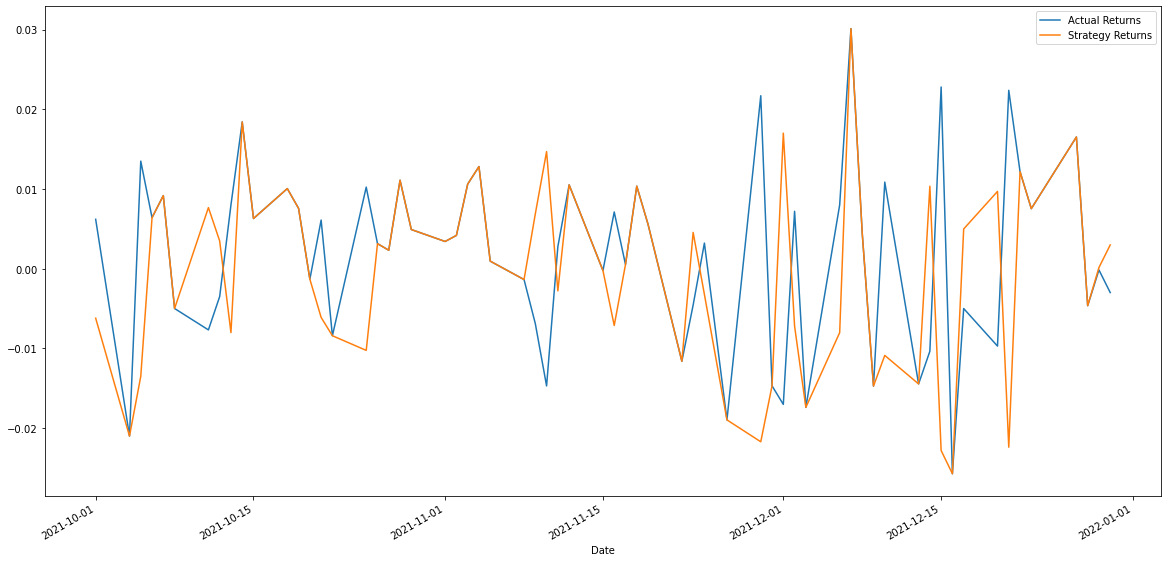

In [24]:
# Plot the actual returns versus the strategy returns
fig, ax = plt.subplots(figsize=(20, 10))
predictions_df[['Actual Returns', 'Strategy Returns']].plot(ax=ax)

<AxesSubplot:title={'center':'SVC Algo'}, xlabel='Date'>

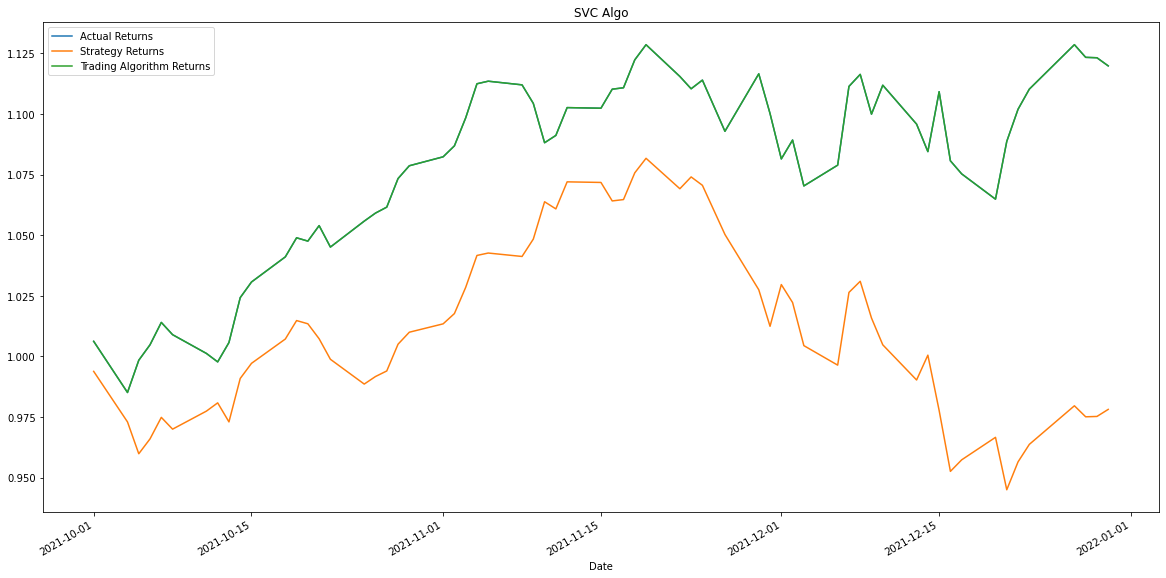

In [25]:
# Calculate and plot the cumulative returns for the `Actual Returns`,`Strategy Returns` and the `Trading Algorithm Returns`
fig, ax = plt.subplots(figsize=(20, 10))
(1 + predictions_df[['Actual Returns', 'Strategy Returns','Trading Algorithm Returns']]).cumprod().plot(
    ax=ax,title='SVC Algo')

# Compare the models

In [26]:
#Imports for Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [27]:
def model_selection(X,Y):
    seed = 7
    models = []
    models.append(('LogisticRegression', LogisticRegression(random_state=seed)))
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    models.append(('RandomForestClassifier', RandomForestClassifier()))
    models.append(('ExtraTreesClassifier',ExtraTreesClassifier(random_state=seed)))
    models.append(('AdaBoostClassifier',AdaBoostClassifier(DecisionTreeClassifier(random_state=seed),random_state=seed,learning_rate=0.1)))
    models.append(('SVM',svm.SVC(random_state=seed)))
    models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=seed)))
    models.append(('MLPClassifier',MLPClassifier(random_state=seed)))

    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed) 
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) 
    return results, names

In [28]:
def plot_models(results, names):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.xticks(rotation=90)
    ax.set_xticklabels(names)
    plt.show()

In [29]:
grid_search = GridSearchCV(estimator = svm_model, param_grid = {}, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1, param_grid={}, verbose=2)

In [30]:
results, names = model_selection(X_train_scaled,y_train)

MLPClassifier: 0.595708 (0.057646)


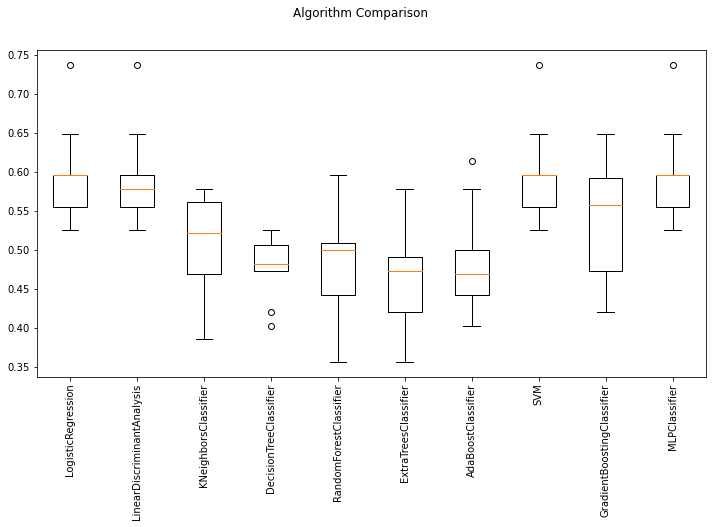

In [31]:
plot_models(results, names)

## MLPClassifier Model

In [38]:
# Create MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(150,100,50), 
                          max_iter=300,activation = 'relu',solver='adam',random_state=1)
mlp_model.fit(X_train_scaled, y_train)
mlp_testing_report = mlp_model.predict(X_test_scaled)

In [39]:
# Print the classification report
print (classification_report(y_test, mlp_testing_report))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        25
         1.0       0.60      1.00      0.75        38

    accuracy                           0.60        63
   macro avg       0.30      0.50      0.38        63
weighted avg       0.36      0.60      0.45        63



/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:

# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_mlp_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_mlp_df['Predicted'] = mlp_testing_report

# Add the actual returns to the DataFrame
predictions_mlp_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_mlp_df['Strategy Returns'] = signals_df['Strategy Returns']

predictions_mlp_df['Trading Algorithm Returns'] = predictions_mlp_df['Actual Returns'] * predictions_mlp_df['Predicted']


# Review the DataFrame
display(predictions_mlp_df.head())
display(predictions_mlp_df.tail())

,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-10-01,1.0,0.006202,-0.006202,0.006202
2021-10-04,1.0,-0.020989,-0.020989,-0.020989
2021-10-05,1.0,0.013499,-0.013499,0.013499
2021-10-06,1.0,0.006408,0.006408,0.006408
2021-10-07,1.0,0.009175,0.009175,0.009175


,Predicted,Actual Returns,Strategy Returns,Trading Algorithm Returns
Date,,,,
2021-12-23,1.0,0.007539,0.007539,0.007539
2021-12-27,1.0,0.016527,0.016527,0.016527
2021-12-28,1.0,-0.004635,-0.004635,-0.004635
2021-12-29,1.0,-0.000149,0.000149,-0.000149
2021-12-30,1.0,-0.002988,0.002988,-0.002988


<AxesSubplot:title={'center':'MLP Returns'}, xlabel='Date'>

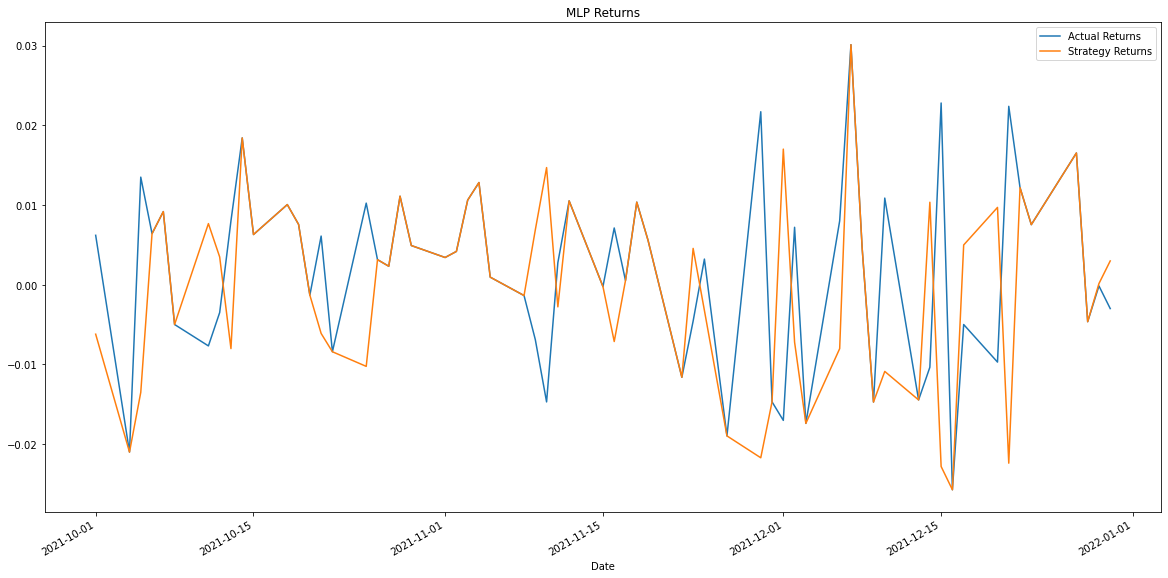

In [45]:
# Plot the actual returns versus the strategy returns
fig, ax = plt.subplots(figsize=(20, 10))
predictions_mlp_df[['Actual Returns', 'Strategy Returns']].plot(ax=ax,title='MLP Returns')

<AxesSubplot:title={'center':'MLP Algo Returns Cumulative'}, xlabel='Date'>

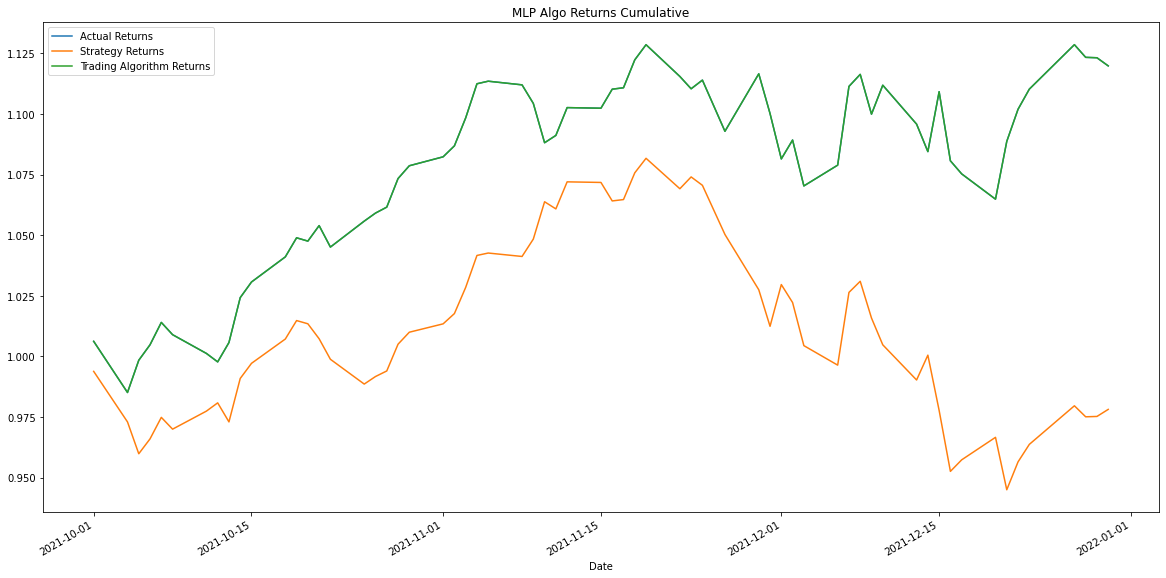

In [46]:
# Calculate and plot the cumulative returns for the `Actual Returns`,`Strategy Returns` and the `Trading Algorithm Returns`
fig, ax = plt.subplots(figsize=(20, 10))
(1 + predictions_mlp_df[['Actual Returns', 'Strategy Returns','Trading Algorithm Returns']]).cumprod().plot(
    ax=ax,title='MLP Algo Returns Cumulative')